## Setup

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from dotenv import load_dotenv
import os

from neo4j import GraphDatabase


import sklearn as skl
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


#### Connect to Neo4j

In [51]:
NEO4J_LOCAL_DATABASE = "busoppdse203"

In [47]:
# Put credentials in .env file

load_dotenv("../.env")

keys = ["DB_USER", "DB_PASSWORD",
    # "NEO4J_USER", "NEO4J_PASSWORD"
    "NEO4J_URI_LOCAL", "NEO4J_USER_LOCAL", "NEO4J_PASSWORD_LOCAL"
    ]
for key in keys:
    if key not in os.environ:
        raise Exception(f"Key '{key}' not found not in .env")
    
print("Credentials from .env file successfully loaded")

Credentials from .env file successfully loaded


In [52]:
# Setup local neo4j instance with the following credentials
local_driver = GraphDatabase.driver(
     os.getenv("NEO4J_URI_LOCAL"),
     auth=(os.getenv("NEO4J_USER_LOCAL"), os.getenv("NEO4J_PASSWORD_LOCAL"))
)

with local_driver.session(database=NEO4J_LOCAL_DATABASE) as session:
    result = session.run("MATCH (n) UNWIND labels(n) AS label RETURN count(DISTINCT label) AS count")
    num_nodes = result.single()["count"]
    print(f"Connection Successful: {num_nodes} unique node types found in the graph database")

Connection Successful: 11 unique node types found in the graph database


In [ ]:
# Setup remote group neo4j instance with the following credentials
# This is the database we will write to and use in our project
group_driver = GraphDatabase.driver(
     "bolt://67.58.49.87:7687",
     auth=("neo4j", "h2u9l4px")
)


# group_driver = GraphDatabase.driver(
#      os.getenv("NEO4J_URI_GROUP"),
#      auth=(os.getenv("NEO4J_USER_GROUP"), os.getenv("NEO4J_PASSWORD_GROUP"))
# )
with group_driver.session() as session:
    result = session.run("MATCH (n) UNWIND labels(n) AS label RETURN count(DISTINCT label) AS count")
    num_nodes = result.single()["count"]
    print(f"Connection Successful: {num_nodes} unique node types found in the graph database")

### Load Data

In [5]:
business_location_df = pd.read_json("../data/business_location.json")
business_location_geometry = [Point(xy) for xy in zip(business_location_df.longitude, business_location_df.latitude)]
# business_location_gdf = gpd.GeoDataFrame(business_location_df, crs="EPSG:4326", geometry=business_location_geometry)
business_location_df = business_location_df[business_location_df['longitude']!=180] #fix these outliers


In [6]:
business_location_df.select_dtypes('number').columns

Index(['id', 'zip', 'latitude', 'longitude', 'blockgroup', 'avg_rating',
       'confidence'],
      dtype='object')

In [11]:
business_location_df = business_location_df.dropna()

In [12]:
# Check column 'A' for decimal values
has_decimals_A = (business_location_df['blockgroup'] != business_location_df['blockgroup'].astype(int)).any()
print(f"Column 'A' has decimal values: {has_decimals_A}")

Column 'A' has decimal values: False


In [19]:
business_location_df['ctblockgroup'] = business_location_df['blockgroup']

In [23]:
block_group_df = pd.read_json("../data/block_group.json")

block_group_df = block_group_df.dropna(axis=1)
block_group_df.head()


,ctblockgroup,medhinc_cy,avghinc_cy,gini_fy,indmanu_cy,totpop_cy,fem25,fem30,fem35,male25,...,population,apportionm,blkgrpce,ogc_fid,statefp,aggregatio,source_cou,geom,geom_ewkt,centroid
0,1001,177856,241985,23.9,112,1198,27,35,32,14,...,2.191,2.576,1,1,6,BlockApportionment:US.BlockGroups;PointsLayer:...,USA,0106000020E610000001000000010300000001000000B8...,SRID=4326;MULTIPOLYGON(((-117.188567830914 32....,0101000020E6100000F9DD3870B24B5DC0799CEE388760...
1,1002,200001,245848,21.9,24,1700,21,40,38,26,...,2.191,2.576,2,2,6,BlockApportionment:US.BlockGroups;PointsLayer:...,USA,0106000020E61000000100000001030000000100000031...,SRID=4326;MULTIPOLYGON(((-117.187773001776 32....,0101000020E6100000AFC67FB20C4C5DC02FD966214060...
2,2011,126652,160491,31.7,34,907,24,19,33,28,...,2.191,2.576,1,3,6,BlockApportionment:US.BlockGroups;PointsLayer:...,USA,0106000020E61000000100000001030000000100000088...,SRID=4326;MULTIPOLYGON(((-117.169610001679 32....,0101000020E61000003299120A344B5DC0EC97B3AF9460...
3,2012,86349,128289,39.1,26,1114,31,26,41,36,...,2.191,2.576,2,4,6,BlockApportionment:US.BlockGroups;PointsLayer:...,USA,0106000020E61000000100000001030000000100000062...,SRID=4326;MULTIPOLYGON(((-117.172342000794 32....,0101000020E6100000779362E9F44A5DC00471F9E05B60...
4,2021,58414,130994,45.3,74,1281,26,35,67,39,...,2.191,2.576,1,5,6,BlockApportionment:US.BlockGroups;PointsLayer:...,USA,0106000020E6100000010000000103000000010000008D...,SRID=4326;MULTIPOLYGON(((-117.172285001534 32....,0101000020E610000037A66881594B5DC022ECE625385F...


## Preprocessing

In [29]:
franchise_mapping = {'FRANCHISE': 1, 'INDEPENDENT': 0}
business_location_df['franchise_bool'] = business_location_df['franchise'].map(franchise_mapping)


In [30]:
bus_block_group_df = pd.merge(business_location_df,block_group_df, on='ctblockgroup', how = "left")

In [25]:
bus_block_group_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39924 entries, 0 to 39923
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            39924 non-null  int64  
 1   name          39924 non-null  object 
 2   url           39924 non-null  object 
 3   address       39924 non-null  object 
 4   city          39924 non-null  object 
 5   zip           39924 non-null  int64  
 6   latitude      39924 non-null  float64
 7   longitude     39924 non-null  float64
 8   blockgroup    39924 non-null  float64
 9   categories    39924 non-null  object 
 10  avg_rating    39924 non-null  float64
 11  franchise     39924 non-null  object 
 12  confidence    39924 non-null  float64
 13  reasoning     39924 non-null  object 
 14  geom_x        39924 non-null  object 
 15  geom_ewkt_x   39924 non-null  object 
 16  ctblockgroup  39924 non-null  float64
 17  medhinc_cy    39924 non-null  int64  
 18  avghinc_cy    39924 non-nu

In [31]:
bus_block_group_df.select_dtypes(include="number").columns

Index(['id', 'zip', 'latitude', 'longitude', 'blockgroup', 'avg_rating',
       'confidence', 'ctblockgroup', 'franchise_bool', 'medhinc_cy',
       'avghinc_cy', 'gini_fy', 'indmanu_cy', 'totpop_cy', 'fem25', 'fem30',
       'fem35', 'male25', 'male30', 'male35', 'crmcytotc', 'di100_cy',
       'di150_cy', 'countyfp', 'tractce', 'population', 'apportionm',
       'blkgrpce', 'ogc_fid', 'statefp'],
      dtype='object')

In [ ]:

target_column = 'avg_rating'


feature_columns = ['zip', 'latitude', 'longitude', 'blockgroup',  'franchise_bool']
# X = business_location_df.dropna()[feature_columns]
# y = business_location_df.dropna()[target_column]


feature_columns = [ 'zip', 'latitude', 'longitude', 'blockgroup', 'franchise_bool','medhinc_cy', 'avghinc_cy', 'gini_fy',
       'indmanu_cy', 'totpop_cy', 'fem25', 'fem30', 'fem35', 'male25',
       'male30', 'male35', 'crmcytotc', 'di100_cy', 'di150_cy']

X = bus_block_group_df.dropna()[feature_columns]
y = bus_block_group_df.dropna()[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Analytics

#### Classical ML

In [41]:
# Linear regression to predict avg_rating from lat lon and franchise


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.39281601100882463
R-squared: 0.04420901982996006


In [42]:
# Polynomial regression to predict avg_rating from lat lon and franchise



polynomial_regressor = Pipeline([('poly_features', PolynomialFeatures(degree=2)),
                                 ('linear_regression', LinearRegression())])

polynomial_regressor.fit(X_train, y_train)
y_poly = polynomial_regressor.predict(X_test)

mse_poly = mean_squared_error(y_test, y_poly)
r2_poly = r2_score(y_test, y_poly)
print(f"Mean Squared Error: {mse_poly}")
print(f"R-squared: {r2_poly}")

Mean Squared Error: 0.39244395869726423
R-squared: 0.04511428904907255


Predicted classes: [0. 0. 0. ... 0. 0. 0.]
Probabilities of class 1: [0.17984746 0.19106259 0.26073176 ... 0.27378181 0.12789405 0.15181177]
Accuracy: 0.7684478371501272
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87      6113
         1.0       0.29      0.03      0.05      1747

    accuracy                           0.77      7860
   macro avg       0.54      0.50      0.46      7860
weighted avg       0.67      0.77      0.69      7860



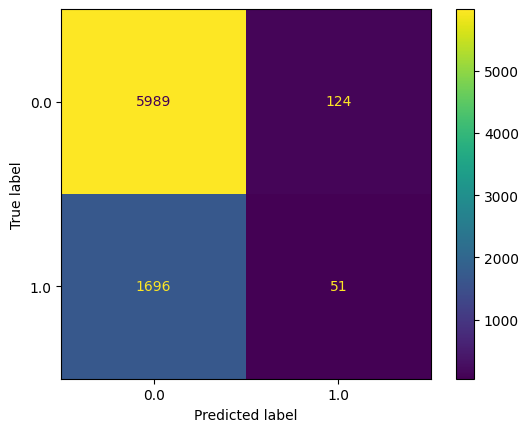

In [36]:
# Logistic regression to classify as franchise or not using avg_rating, lat and lon
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])



Xf = business_location_df.dropna()[['latitude', 'longitude','avg_rating','zip','blockgroup']]
yf = business_location_df.dropna()['franchise_bool']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.2, random_state=42)


model.fit(Xf_train, yf_train)

# Predict the class label (0 or 1)
yf_logist = model.predict(Xf_test)
print(f"Predicted classes: {yf_logist}")

# Predict the probability of belonging to class 1
yf_probabilities = model.predict_proba(Xf_test)[:, 1] #
print(f"Probabilities of class 1: {yf_probabilities}")




print(f"Accuracy: {accuracy_score(yf_test, yf_logist)}")
print("Classification Report:")
print(classification_report(yf_test, yf_logist))

cm_logist = confusion_matrix(yf_test, yf_logist)


disp = ConfusionMatrixDisplay.from_estimator(model, Xf_test, yf_test)


#### Graph ML

We cant use these yet as we dont have access to the graph data science library on the server yet

In [71]:
# project the graph

# query = """
# CALL gds.graph.project(
#     "businesses",
#     "BusinessLocation",
#     "*"
# )

# """


query = """
CALL gds.graph.project(
    "businesses_and_blockgroups",
    ["BusinessLocation", "BlockGroup"], 
    "*"                                 
)
YIELD
    graphName,
    nodeCount,
    relationshipCount,
    projectMillis;


"""

with local_driver.session(database=NEO4J_LOCAL_DATABASE) as session:
    result = session.run(query
    )
    for record in result:
        print(record)
   

<Record graphName='businesses_and_blockgroups' nodeCount=41678 relationshipCount=591730 projectMillis=860>


In [72]:


query = """ 

CALL gds.graph.list("businesses_and_blockgroups")
YIELD graphName, nodeCount, relationshipCount, configuration, schema
RETURN graphName, nodeCount, relationshipCount, configuration, schema;


"""
with local_driver.session(database=NEO4J_LOCAL_DATABASE) as session:
    result = session.run(query
    )
    for record in result:
        print(record)



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('schema' returned by 'gds.graph.list' is deprecated.)} {position: line: 4, column: 63, offset: 115} for query: ' \n\nCALL gds.graph.list("businesses_and_blockgroups")\nYIELD graphName, nodeCount, relationshipCount, configuration, schema\nRETURN graphName, nodeCount, relationshipCount, configuration, schema;\n\n\n'


<Record graphName='businesses_and_blockgroups' nodeCount=41678 relationshipCount=591730 configuration={'relationshipProjection': {'__ALL__': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse': False, 'properties': {}, 'type': '*'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': 'ec4fef83-c9bd-43c5-ae70-6fa91593b704', 'nodeProjection': {'BlockGroup': {'label': 'BlockGroup', 'properties': {}}, 'BusinessLocation': {'label': 'BusinessLocation', 'properties': {}}}, 'logProgress': True, 'validateRelationships': False, 'sudo': False} schema={'graphProperties': {}, 'nodes': {'BlockGroup': {}, 'BusinessLocation': {}}, 'relationships': {'__ALL__': {}}}>


In [ ]:
query= """ 

CALL gds.degree.write("businesses_and_blockgroups", {
    writeProperty: 'degreeScore'
})
YIELD   computeMillis, writeMillis
RETURN  computeMillis, writeMillis;
"""

with local_driver.session(database=NEO4J_LOCAL_DATABASE) as session:
    result = session.run(query
    )
    for record in result:
        print(record)


#Afterwards run the following query directly on neo4j to find the top 10 nodes based on the calculated degreeScore
query = """
MATCH (n)"
WHERE n.degreeScore IS NOT NULL
WITH n
ORDER BY n.degreeScore DESC
LIMIT 10

MATCH p = ()-[r1*1..3]-(n)-[r2*1..3]-() 

RETURN p

LIMIT 1000

"""

SyntaxError: invalid syntax (4021601499.py, line 18)